## Local Polynomial Regression

Local Polynomial Regression is a non-parametric technique that aims to fit a polynomial model to localized subsets of data to produce a smooth curve over the

range of the data.

### Main Concepts

1. **Higher-order Polynomials:** Increasing the polynomial degree may reduce bias but may also result in a higher variance. The choice of polynomial degree can impact the balance between bias and variance.

   $$
   \text{Bias-Variance Tradeoff: } \text{Bias}^2 + \text{Variance} = \text{Error}
   $$

2. **Local Fits:** Local linear fits can help in reducing linear bias, especially at the boundaries. Meanwhile, local quadratic fits can effectively reduce the bias due to curvature in the central part but might increase variance near the boundaries.

3. **Kernel Weighting:** Points closer to the target location are given more weight in the local fit than those farther away. This is achieved using a kernel function, commonly the Gaussian kernel:

   $$
   K(z) = \frac{e^{-z^2/2}}{\sqrt{2\pi}}
   $$

### Confidence Intervals

The 95% confidence intervals for the estimates are computed as:

$$
\hat{y}_{\text{lower}} = \hat{y} - z \times \text{SE}
$$
$$
\hat{y}_{\text{upper}} = \hat{y} + z \times \text{SE}
$$

Where:
- $ \hat{y} $ is the estimate.
- $ z $ is the z-value for a 95% confidence level.
- SE (Standard Error) is the standard error of the estimate.

<b>Reference:</b> From GaTech ISYE 8803 High Dimensional Data Analytics lecture notes, enhanced with ChatGPT.

Optimal bandwidth h: 0.09


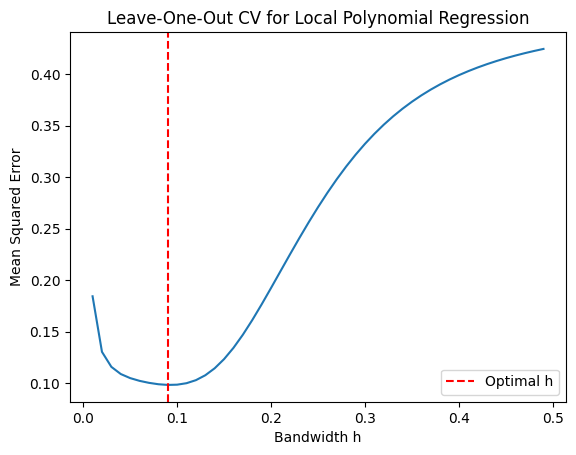

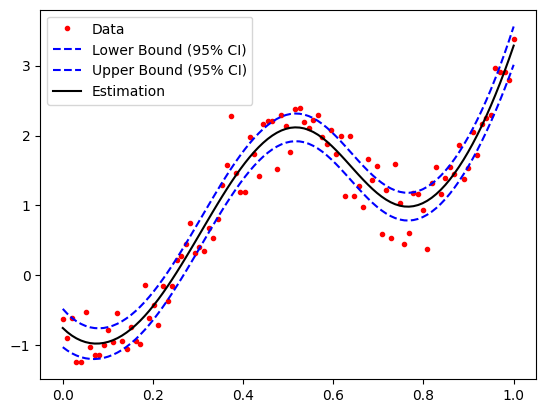

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Data generation
n = 100
D = np.linspace(0, 1, n)
sigma = 0.3
fun = lambda x: 2.5 * x - np.sin(10 * x) - np.exp(-10 * x)
y = fun(D) + np.random.randn(n) * sigma

# Gaussian kernel function
kerf = lambda z: np.exp(-z**2 / 2) / np.sqrt(2 * np.pi)

# Local polynomial regression prediction (quadratic)
def local_polynomial_regression(x0, X, Y, h):
    weights = kerf((x0 - X) / h)
    
    W = np.diag(weights)
    b = np.array([np.ones_like(X), X, X**2]).T
    beta = np.linalg.solve(b.T @ W @ b, b.T @ W @ Y)
    
    return beta[0] + beta[1] * x0 + beta[2] * x0**2

# Leave-one-out CV
h_values = np.arange(0.01, 0.5, 0.01)
mse = []

for h in h_values:
    errors = []
    for i in range(n):
        mask = np.ones(n, bool)
        mask[i] = 0
        X1, Y1 = D[mask], y[mask]
        
        y_hat = local_polynomial_regression(D[i], X1, Y1, h)
        error = y[i] - y_hat
        errors.append(error)
    
    mse.append(np.mean(np.array(errors)**2))

# Optimal bandwidth
h_optimal = h_values[np.argmin(mse)]
print("Optimal bandwidth h:", h_optimal)

# Plotting
plt.plot(h_values, mse)
plt.axvline(x=h_optimal, color='red', linestyle='--', label='Optimal h')
plt.xlabel('Bandwidth h')
plt.ylabel('Mean Squared Error')
plt.title('Leave-One-Out CV for Local Polynomial Regression')
plt.legend()
plt.show()

# Local polynomial regression estimate using optimal bandwidth
yhat_best = np.zeros(n)
for i in range(n):
    yhat_best[i] = local_polynomial_regression(D[i], D, y, h_optimal)

# Calculate 95% confidence intervals
alpha = 0.05
z_val = np.abs(np.percentile(np.random.randn(10000), 100*(1-alpha/2)))  # z-value for 95% confidence
stderr = sigma / np.sqrt(np.sum(kerf((D - D[:, np.newaxis]) / h_optimal), axis=1))
yn = yhat_best - z_val * stderr
yp = yhat_best + z_val * stderr

# Plot function
plt.plot(D, y, 'r.', label='Data')
plt.plot(D, yn, 'b--', label='Lower Bound (95% CI)')
plt.plot(D, yp, 'b--', label='Upper Bound (95% CI)')
plt.plot(D, yhat_best, 'k-', label='Estimation')
plt.legend()
plt.show()
